# Module 8 #

Convert a 3D image into a spherical harmonic representation using CellOrganizer SPHARM-RPDM functionality

Then create both a mesh reconstruction and an image reconstruction from the SPHARM-RPDM representation 


In [1]:
#import packages
from aicsimageio import AICSImage
import numpy as np
from pathlib import Path
from cellorganizer.tools import image2SPHARMparameterization, SPHARMparameterization2image, SPHARMparameterization2mesh
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

# Image 2 SPHARM PARAMS #

In [2]:
#set options
# options = {}
# options['NMfirsttry_maxiter'] = 300
# options['NMretry_maxiter'] = 100
# options['NMretry_maxiterbig'] = 300

# # decreasing these numbers decreases compute time but potential reduces model quality
# options['NMcost_tol'] = 1e-7
# options['NMlargr_tol'] = 1e-7

# # degree of spherical harmonic descriptor
# options['maxDeg'] = 31
# # if the error in the parameterization for a given cell is higher than this, discard that cell
# # (note that there is a separate option hd_threshold that controls which cells are in reports)
# options['hd_thresh'] = 10

In [3]:
#read in selected image
directory = '/home/murphylab/cellorganizer/local/images/HeLa/3D/processed/'
cellImagesDirectoryPath = Path(directory + 'LAM_cell1_ch1_t1.tif')
img = AICSImage(cellImagesDirectoryPath)

In [4]:
data = img.data
data = np.squeeze(data) #get it down to a 3D image
data = np.transpose(data, (1, 2, 0)) #transpose to xyz
print(data.shape)
#downsample
data = data[::8,::8,::2]
#make sure data is shaped correctly
print(data.shape)

(1024, 1024, 18)
(128, 128, 9)


In [5]:
#print(np.max(data))
print(data[75,48,0])

0


In [ ]:
params = image2SPHARMparameterization(data) #return back descriptors as dict
#params = image2SPHARMparameterization(data, options) #if you have user specificed options otherwise it will use defaults

In [7]:
params

{'deg': 31,
 'fvec': array([[ 2.37426501e+02-9.10650698e-19j,  2.82660044e+02+1.49509817e-18j,
          1.36039404e+01+8.84799651e-20j],
        [ 4.68013160e+01+6.38149823e+00j, -9.84665176e+00-1.85491037e+01j,
         -1.27629979e+00+7.79107474e+00j],
        [-8.22823462e+00-4.83286628e-18j, -6.80130984e+01-2.37840137e-18j,
         -3.64571401e+00+2.22047106e-19j],
        ...,
        [ 4.23640849e-03+2.25153693e-03j, -2.52885369e-02-3.69842057e-03j,
         -7.64317684e-03-6.15977006e-03j],
        [-8.47827622e-04-1.15641368e-02j,  1.61398172e-03+1.33289658e-03j,
         -3.22801147e-03+1.42057690e-02j],
        [-5.42255986e-03+2.37750576e-02j, -7.27744590e-03-6.68005570e-03j,
          8.54299497e-03-2.31560368e-03j]]),
 'vertices': array([[ 60,  37,   0],
        [ 61,  37,   0],
        [ 62,  37,   0],
        ...,
        [ 70, 102,   9],
        [ 71, 102,   9],
        [ 72, 102,   9]], dtype=uint8),
 'faces': array([[3923, 3892, 3067, 3080],
        [3928, 3895, 307

# SPHARM PARAMS 2 MESH #

In [8]:
#set options
options = {}

###NOT DEFAULTS####
#options['meshtype.type'] = 'even'
#options['meshtype.nPhi'] = 64
#options['meshtype.nTheta'] = 32
###################

options['meshtype.type'] = 'triangular';
options['meshtype.nVertices'] = 4002;

# options['figtitle'] = []
# options['plot'] = 0 #show mesh figure
# options['dpi'] = 150

In [9]:
mesh_mat = SPHARMparameterization2mesh(params, options)

CellOrganizer v2.10 (MATLAB RO2019a)


In [10]:
mesh_mat

{'Zvert': array([[ 59.74109373,  34.54861069,   0.60274644],
        [ 58.7310477 ,  32.51924982,   0.76938547],
        [ 60.74788916,  37.47191639,   0.37580302],
        ...,
        [ 68.11132005, 106.65890227,   5.80092412],
        [ 70.54207303, 106.3611583 ,   5.74170125],
        [ 69.8682633 , 106.29772191,   5.92581622]]),
 'fs': array([[1971, 2115, 2026],
        [1759, 1903, 1814],
        [1759, 1848, 1903],
        ...,
        [3692, 3747, 3713],
        [3692, 3726, 3747],
        [3726, 3781, 3747]], dtype=uint16)}

4002
8000


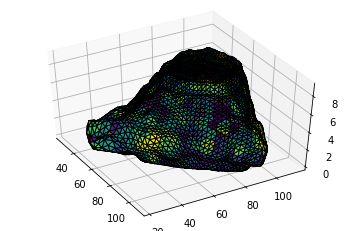

In [11]:
# now create a 3D visualization from the mesh

# vertices
v = mesh_mat['Zvert']
print(len(v))
# faces
f = mesh_mat['fs']-1
print(len(f))

# assign a "color number" equal to the index of the face
C = np.array(list(range(len(mesh_mat['fs']))))
## an alternative is to assign each face a "color number" matching its average z coordinate
#C=np.empty(len(f))
#for itup in range(len(f)):
#    C[itup]=np.mean(v[f[itup]], axis=0)[2]
# normalize the color numbers to range 0-1
norm = plt.Normalize(C.min(), C.max())
# assign a color to each face
colors = plt.cm.viridis(norm(C))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black")
ax.add_collection(pc)
vmins = np.amin(v, axis=0)
vmaxs = np.amax(v, axis=0)
ax.set_xlim(vmins[0], vmaxs[0])
ax.set_ylim(vmins[1], vmaxs[1])
ax.set_zlim(vmins[2], vmaxs[2])

elevation = 45
azimuth = 330
ax.view_init(elevation, azimuth)
plt.show()

# SPHARM PARAMS 2 IMAGE #

In [12]:
# options['cropping'] = 'tight'
# options['oversampling_scale'] = 1
# options['debug'] = True
print(options)
img_mat = SPHARMparameterization2image(params, options)
print(img_mat.shape)

{'meshtype.type': 'triangular', 'meshtype.nVertices': 4002}
CellOrganizer v2.10 (MATLAB RO2019a)
(117, 114, 9)


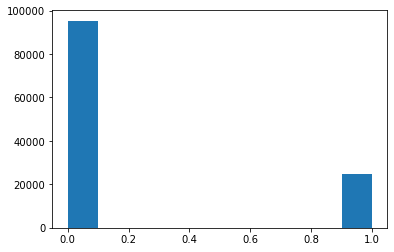

In [13]:
fig=plt.figure()
plt.hist(img_mat.ravel())
plt.show()

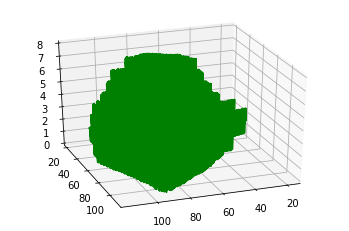

In [14]:
abovezeroind = np.argwhere(img_mat)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.view_init(elev=30, azim=70)  
ax.plot3D(abovezeroind[:,0],abovezeroind[:,1],abovezeroind[:,2],'green')
plt.show()

3


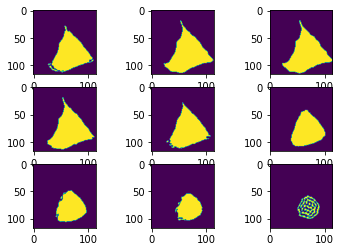

In [15]:
fig = plt.figure()
#islice = round(img_mat.shape[2]/2)
import math
panels = math.ceil(math.sqrt(img_mat.shape[2]))
print(panels)
for i in range(img_mat.shape[2]):
    plt.subplot(panels,panels,i+1)
    plt.imshow(img_mat[:,:,i])
plt.show()